In [3]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import os
import seaborn
import sklearn.metrics

import gpu_setup

device = gpu_setup.gpu_setup(0)


Using GPU: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
out = './result'
os.makedirs(out, exist_ok=True)


In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # [0,1]に正規化

x_train = x_train[..., np.newaxis].astype(np.float32)
x_test = x_test[..., np.newaxis].astype(np.float32)

# データセットのランダム化
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)


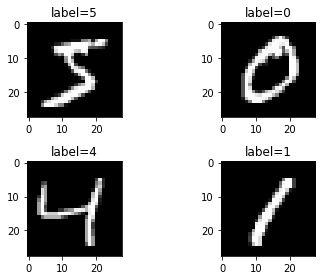

In [6]:
fig = plt.figure()
for i in range(4):
  ax = fig.add_subplot(2, 2, i+1)
  ax.imshow(x_train[i].reshape(28,28), 'gray')
  ax.set_title('label={}'.format(y_train[i]))
plt.tight_layout()
plt.show()


In [8]:
x_train.shape

(60000, 28, 28, 1)

In [9]:
class CNV(tf.keras.Model):
    def __init__(self):
        super(CNV, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


In [13]:
model = CNV()
input_shape=(1, 28, 28, 1)
model.build(input_shape)

model.load_weights('./result/model.h5')

loss_func= tf.keras.losses.SparseCategoricalCrossentropy()
#optimizer = tf.keras.optimizers.Adam()


5


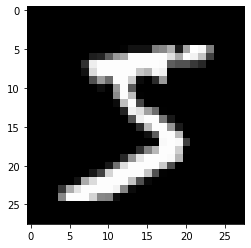

In [40]:
x_train.shape
target = x_train[0]
target = tf.constant(target.reshape(1,28,28,1))

target_label = y_train[0]

plt.figure()
plt.imshow(target.numpy().reshape(28, 28), 'gray')

print(target_label)

tf.Tensor(
[[1.8070275e-17 8.4661015e-19 4.0370234e-19 1.8856873e-06 4.3707904e-21
  9.9999809e-01 1.4659568e-17 1.0786998e-18 3.3842391e-12 7.1980713e-13]], shape=(1, 10), dtype=float32)


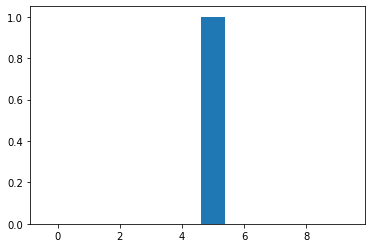

In [41]:
def predict(target, model):
    pre = model( target)
    print( pre )
    plt.figure()
    plt.bar(list(range(10)), pre.numpy().reshape(-1))

predict(target, model)

(1, 28, 28, 1)
tf.Tensor(
[[1.7280943e-16 3.9019473e-17 7.3171317e-16 9.8966241e-01 7.2976039e-20
  1.0337573e-02 1.1537742e-17 6.8900857e-16 6.6403813e-11 1.0240951e-11]], shape=(1, 10), dtype=float32)


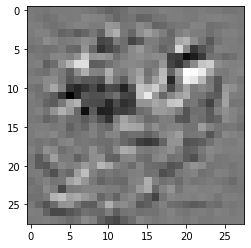

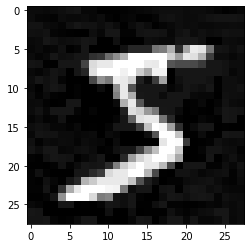

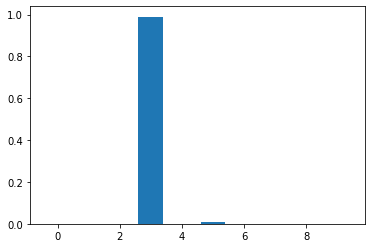

In [57]:
with tf.GradientTape() as tape:
    tape.watch(target)
    pre = model(target)
    loss = loss_func(target_label, pre)
    grads = tape.gradient(loss, target)
target = target + (1/255)*tf.sign(grads)
print(grads.shape)
plt.figure()
plt.imshow(grads.numpy().reshape(28,28), 'gray')
plt.figure()
plt.imshow(target.numpy().reshape(28, 28), 'gray')
predict(target, model)

-0.047058824 0.047059417


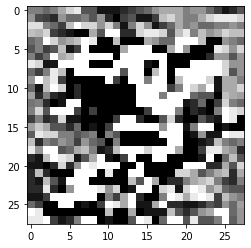

In [58]:
perturbation = target.numpy().reshape(28,28)-x_train[0].reshape(28,28)
plt.figure()
plt.imshow(perturbation, 'gray')
print(perturbation.min(), perturbation.max())

In [51]:
epoch = 10 # 更新の繰り返し回数

with tf.device(device): 
    for e in range(epoch):
      # train
      train_losses = []
      for images, labels in train_ds:
        with tf.GradientTape() as tape: # 自動微分機能を使う
          pre = model(images) # 推論
          loss = loss_func(labels, pre) # 誤差を計算
          train_losses.append(loss.numpy())

        grad = tape.gradient(loss, model.trainable_variables) # 勾配を求める
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # 勾配を更新規則に従って重みパラメータに反映

#       # test
#       test_losses = []
#       for images, labels in test_ds:
#         pre = model(images)
#         loss = loss_func(labels, pre)
#         test_losses.append(loss.numpy())

      print("Epoch:{}, train_loss:{}, test_loss{}"
            .format(e, np.mean(train_losses), np.mean(test_losses)))


NameError: name 'optimizer' is not defined

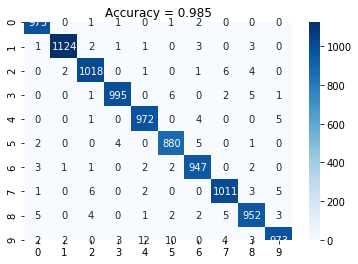

In [9]:
# テスト
predict = []
for images, labels in test_ds:
  pre = model(images)
  predict.append(pre)

predict = np.concatenate(predict, axis=0)
pre_label = np.argmax(predict, axis=1)

confmat = sklearn.metrics.confusion_matrix(y_test, pre_label)
fig = plt.figure()
ax = fig.add_subplot(111)
seaborn.heatmap(confmat, ax=ax, annot=True, fmt="d", cmap="Blues")
acc = np.sum(np.asarray(y_test) == np.asarray(pre_label))/len(y_test)
ax.set_title("Accuracy = {:.3f}".format(acc))
plt.show()



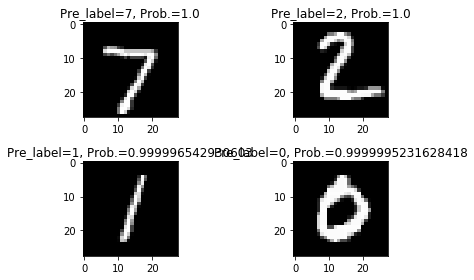

In [10]:
# 表示してみる
fig = plt.figure()
for i in range(4):
  ax = fig.add_subplot(2, 2, i+1)
  ax.imshow(x_test[i].reshape(28,28), 'gray')
  pre = model(x_test[i][tf.newaxis, ...])
  ax.set_title('Pre_label={}, Prob.={}'
                .format(np.argmax(pre.numpy()), np.max(pre.numpy())))
plt.tight_layout()
plt.show()



In [11]:
# Save
model.save_weights(os.path.join(out, 'model.h5'))